## In this notebook, we will be testing the model real-time to check out its inference speed and the resulting frames per second (fps). After which, we will deploy a Gradio demo on Hugging Face spaces. The demo will accept both image and video inputs with the following parameters that can be adjusted (IoU threshold for Non-Maximum Suppression (NMS), confidence threshold, classes to be detected and whether or not to display the masks only.

## Deployed Gradio Demo link: https://huggingface.co/spaces/purplelord2003/Urban_Segmentor

### Testing the model's speed in real-time: We will try out the model using our webcam as well as an imported video. Note that this may not work in Google Colab (I am running this notebook locally).

In [ ]:
# Clone my repository
!git clone https://github.com/purplelord2003/Segmentation-Model

Cloning into 'Segmentation-Model'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 13), reused 22 (delta 4), pack-reused 0
Receiving objects: 100% (61/61), 49.57 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Filtering content: 100% (4/4), 265.69 MiB | 33.34 MiB/s, done.


In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
### Testing using our webcam! This gives an output file. (note this may not work in Google Colab) ###

import cv2
from ultralytics import YOLO
from timeit import default_timer as timer

model = YOLO("Segmentation-Model/Demo Preparation/best.pt")  # segmentation model

cap = cv2.VideoCapture(0)
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('webcam.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

while cap.isOpened():
    success, frame = cap.read()

    if success:
        # Start timer
        start_time = timer()

        # Run model inference on the frame
        results = model.predict(frame, iou=0.5)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # End timer
        end_time = timer()

        # Calculate and display fps
        frames_per_second = round(1 / (end_time - start_time))
        annotated_frame = cv2.putText(annotated_frame, f'FPS: {frames_per_second}', (30, 100), cv2.FONT_HERSHEY_SIMPLEX,
                                      2, (0, 0, 255), 2, cv2.LINE_AA)

        # Write annotated frame to outfile
        out.write(annotated_frame)

        # Open outfile, displaying annotated image
        cv2.imshow("instance-segmentation", annotated_frame)

        # Quits when the video ends or when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            out.release()
            cap.release()
            cv2.destroyAllWindows()
            break

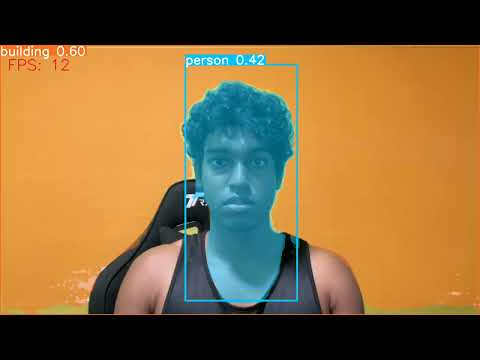

In [ ]:
# Display output (open in YouTube if needed) - also available in my repo
from IPython import display
display.YouTubeVideo("gW-g1obeab0")

In [ ]:
### Testing using an imported video! This gives an output file. (note that this may not work in Google Colab) ###

import cv2
from ultralytics import YOLO
from timeit import default_timer as timer

model = YOLO("Segmentation-Model/Demo Preparation/best.pt")  # segmentation model

cap = cv2.VideoCapture("Example 1.mp4")
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('instance-segmentation.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

while cap.isOpened():
    success, frame = cap.read()

    if success:
        # Start timer
        start_time = timer()

        # Run model inference on the frame
        results = model.predict(frame, iou=0.5)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # End timer
        end_time = timer()

        # Calculate and display fps
        frames_per_second = round(1 / (end_time - start_time))
        annotated_frame = cv2.putText(annotated_frame, f'FPS: {frames_per_second}', (30, 100), cv2.FONT_HERSHEY_SIMPLEX,
                                      2, (0, 0, 255), 2, cv2.LINE_AA)

        # Write annotated frame to outfile
        out.write(annotated_frame)

        # Open outfile, displaying annotated image
        cv2.imshow("instance-segmentation", annotated_frame)

        # Quits when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            out.release()
            cap.release()
            cv2.destroyAllWindows()
            break

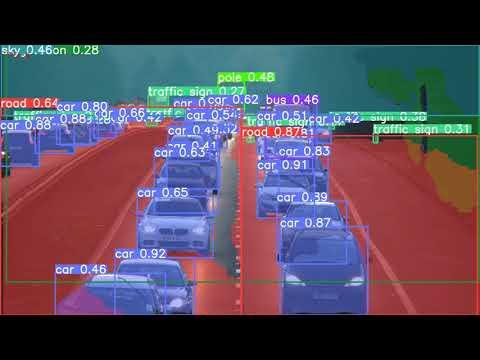

In [ ]:
# Display output (open in YouTube if needed) - also available in my repo
display.YouTubeVideo("MlX9ESjrlZM")

### It seems that we achieve a real-time fps of about 12 fps for webcam and drops to about 8 fps for the imported video (probably due to a much higher detections and masks in the imported video). Ideally, we want the fps to be as high as possible (nearer to 60) but this model was run on my laptop's CPU and thus, the deployment fps on a GPU would probably be much closer to 60fps.

# Deploying model to Hugging Face Spaces using a Gradio demo

In [ ]:
from pathlib import Path


# Create demos folder
urban_segmentor_demo_path = Path("demos/urban_segmentor/")

if urban_segmentor_demo_path.exists():
  print("Directory already exists")

else:
  urban_segmentor_demo_path.mkdir(parents=True,
                                 exist_ok=True)

## Getting examples
I have already collected the examples for image and video instance segmentation.
For the image segmentation, I used 3 images from the testing dataset and an image I found online.
For the video segmentation, I used 3 videos I found online.

In [ ]:
# Get examples directory (already collated in my repo)
!mv "Segmentation-Model/Demo Preparation/Examples" "demos/urban_segmentor"

## Writing requirements.txt

In [ ]:
%%writefile demos/urban_segmentor/requirements.txt
torch==2.2.0
cv2==4.9.0
ultralytics==8.1.13
gradio==4.19.0

Writing demos/urban_segmentor/requirements.txt


## Write app.py

In [ ]:
%%writefile demos/urban_segmentor/app.py
import cv2
import gradio as gr
import ultralytics
import os
from ultralytics import YOLO
from typing import List

# Create model with imported weights
model = YOLO("best.pt")
model.to("cpu") # Hugging Face Spaces offers free cpu only

# Make class list
classes =[
'road',
'sidewalk',
'building',
'wall',
'fence',
'pole',
'traffic light',
'traffic sign',
'vegetation',
'terrain',
'sky',
'person',
'rider',
'car',
'truck',
'bus',
'train',
'motorcycle',
'bicycle',
]


# Prediction function for image
def image_predict(image_input: gr.Image=None, image_iou_threshold: float=0.7, image_score_threshold: float=0.25,
                  image_class_list: List[int]=None, image_show_masks_only: bool=False):

    # Model makes predictions
    results = model.predict(image_input, iou=image_iou_threshold, conf=image_score_threshold, classes=image_class_list)

    # Annotate the predictions on the image
    annotated_img = results[0].plot(line_width=2, boxes=not(image_show_masks_only))
    annotated_img = annotated_img[:, :, ::-1] # inverting the colours back to PIL format

    return annotated_img

# Prediction function for video
def video_predict(video_input: gr.Video=None, video_iou_threshold: float=0.7, video_score_threshold: float=0.25,
                  video_class_list: List[int]=None, video_show_masks_only: bool=False):

    # Open video
    cap = cv2.VideoCapture(video_input)

    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

    # Gradio supports avc1
    out = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    # Loop through the video frames
    while cap.isOpened():

        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Model makes predictions
            results = model.predict(frame, iou=video_iou_threshold, conf=video_score_threshold, classes=video_class_list)

            # Annotate the predictions on the frame
            annotated_frame = results[0].plot(line_width=3, boxes=not(video_show_masks_only))

            # Write the annotated frame to the outfile
            out.write(annotated_frame)

        else:
            # Break the loop once video ends
            break

    # Release video capture
    cap.release()

    # Return the path to outfile
    return "output.mp4"



# Gradio interface


with gr.Blocks() as demo:
    gr.Markdown(
        """
        # Urban Segmentor

        Perform Instance Segmentation of an image or video! The model was created by training the [YOLOv8](https://docs.ultralytics.com/models/yolov8/) instance segmentation model on the [cityscapes dataset](https://www.cityscapes-dataset.com) which is a dataset on urban landscapes to perform instance segmentation for 19 classes (see options below). Trained at [Urban Segmentor (training).ipynb](https://colab.research.google.com/drive/1LjnUBLQ1y4mCEf9t-piHyEjE56BRC8I4#scrollTo=620ANSFqY77h)
        Try to adjust [Intersection over Union (IoU) threshold](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/) to be lower if multiple detections of the same object detected. Try to adjust score threshold to be lower if desired object not detected. You can choose to detect/mask specific classes and also view masks only. Examples are defaulted at 0.7 IoU threshold and 0.25 scores threshold, detect all classes and view masks only set to False. You can download the output image/video to see all the labels clearly. Video prediction time can take several minutes (running on a slow free cpu).
        """
               )
    with gr.Tab("Image Instance Segmentation"):
        with gr.Row():
            image_input = gr.Image(type="pil", label="Input Image")
            image_output = gr.Image(type="pil", label="Output Image")
        image_iou_threshold = gr.Slider(minimum=0, maximum=1, value=0.7, step=0.01, label="Intersection over Union (IoU) Threshold")
        image_score_threshold = gr.Slider(minimum=0, maximum=1, value=0.25, step=0.01, label="Score Threshold")
        image_class_list = gr.CheckboxGroup(label="Classes to detect for", type="index", interactive=True, value=classes,
        choices=classes)
        image_show_masks_only = gr.Checkbox(label="Show segmentation masks only? (Remove bounding boxes, labels and probabilites)", interactive=True, value=False)
        image_button = gr.Button("Submit")
        image_inputs_all = [image_input, image_iou_threshold, image_score_threshold, image_class_list, image_show_masks_only]
        gr.Examples(examples=[["Examples/Images/" + example] for example in os.listdir("Examples/Images")], inputs=image_inputs_all, outputs=[image_output], cache_examples=True, fn=image_predict)

    with gr.Tab("Video Instance Segmentation"):
        with gr.Row():
            video_input = gr.Video(label="Input Video")
            video_output = gr.Video(label="Output Video")
        video_iou_threshold = gr.Slider(minimum=0, maximum=1, value=0.7, step=0.01, label="Intersection over Union (IoU) Threshold")
        video_score_threshold = gr.Slider(minimum=0, maximum=1, value=0.25, step=0.01, label="Score Threshold")
        video_class_list = gr.CheckboxGroup(label="Classes to detect for", type="index", interactive=True, value=classes,
        choices=classes)
        video_show_masks_only = gr.Checkbox(label="Show segmentation masks only? (Remove bounding boxes, labels and probabilites)", interactive=True)
        video_button = gr.Button("Submit")
        video_inputs_all = [video_input, video_iou_threshold, video_score_threshold, video_class_list, video_show_masks_only]
        gr.Examples(examples=[["Examples/Videos/" + example] for example in os.listdir("Examples/Videos")], inputs=video_inputs_all, outputs=[video_output], cache_examples=True, fn=video_predict)


    image_button.click(image_predict, inputs=image_inputs_all, outputs=[image_output])
    video_button.click(video_predict, inputs=video_inputs_all, outputs=[video_output])

demo.launch()

Writing demos/urban_segmentor/app.py


In [ ]:
# Getting the model (made in previous notebook)
!mv "Segmentation-Model/Demo Preparation/best.pt" "demos/urban_segmentor"

In [ ]:
# Zip folder but exclude certain files
!cd demos/urban_segmentor && zip -r ../urban_segmentor.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 66%)
  adding: best.pt (deflated 8%)
  adding: Examples/ (stored 0%)
  adding: Examples/Images/ (stored 0%)
  adding: Examples/Images/Example 1.png (deflated 0%)
  adding: Examples/Images/Example 4.png (deflated 0%)
  adding: Examples/Images/Example 2.png (deflated 0%)
  adding: Examples/Images/Example 3.png (deflated 0%)
  adding: Examples/.DS_Store (deflated 93%)
  adding: Examples/Videos/ (stored 0%)
  adding: Examples/Videos/Example 2.mp4 (deflated 1%)
  adding: Examples/Videos/.DS_Store (deflated 96%)
  adding: Examples/Videos/Example 1.mp4 (deflated 0%)
  adding: Examples/Videos/Example 3.mp4 (deflated 0%)
  adding: requirements.txt (deflated 7%)


In [ ]:
from google.colab import files
files.download('demos/urban_segmentor.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Pushing the unzipped file to Hugging Face spaces will create the demo app.
## Link to the app: https://huggingface.co/spaces/purplelord2003/Urban_Segmentor